In [49]:
import argparse
import logging
import os
import glob

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet import NET
from utils.utils import plot_img_and_mask
import matplotlib.pyplot as plt

In [50]:
output_depths = np.zeros((180, 3, 400, 400))

In [51]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                index=0
                ):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        output_depths[index] = output.squeeze(0).numpy()

    return output.squeeze(0).numpy()

In [52]:
def get_output_filenames(args):
    def _generate_name(fn):
        return f'{os.path.splitext(fn)[0]}_OUT.png'

    return args.output or list(map(_generate_name, args.input))

In [53]:
def mask_to_image(mask: np.ndarray):
    # if isinstance(mask_values[0], list):
    mask = mask.transpose(1, 2, 0)
    # return Image.fromarray((mask*255).astype(np.uint8))
    return mask

In [54]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args = Args(**{
    "model": "checkpoints/checkpoint_epoch20.pth",
    "input_dir": "./data/pothole600/test/rgb/",
    "output": "./predict/outdepths/",
    "viz": True,
    "no_save": False,
    "mask_threshold": 0.5,
    "scale": 1,
    "bilinear": False
})
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

in_files = glob.glob(args.input_dir + "/*.png")
out_files = [f.replace(args.input_dir, args.output) for f in in_files]

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {args.model}')
logging.info(f'Using device {device}')

INFO: Loading model checkpoints/checkpoint_epoch20.pth
INFO: Using device cuda


In [56]:
# net = UNet(n_channels=3, n_classes=2, bilinear=args.bilinear)
net = NET(classes=3)
net.to(device=device)
# state_dict = torch.load(args.model, map_location=device)
# mask_values = state_dict.pop('mask_values')
net.load_state_dict(torch.load(args.model, map_location=device))

logging.info('Model loaded!')

INFO: Model loaded!


In [57]:
# create output dir if not exists
if not os.path.exists(args.output):
    os.makedirs(args.output)

In [58]:

for i, filename in enumerate(in_files):
    # logging.info(f'Predicting image {filename} ...')
    img = Image.open(filename)

    mask = predict_img(net=net,
                        full_img=img,
                        scale_factor=args.scale,
                        device=device,
                        index=i
                       )

In [59]:
np.min(output_depths[0, 0, :, :])

# N, C, H, W ---> N, H, W, C
output_depths = output_depths.transpose(0, 2, 3, 1)

(-0.5, 399.5, 399.5, -0.5)

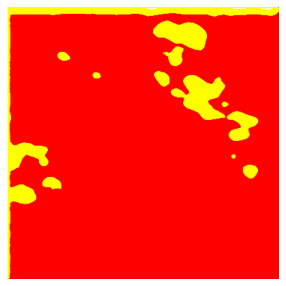

In [66]:
# plotting
fig = plt.figure(figsize=(5, 5))
plt.imshow(output_depths[5])
plt.axis('off')